In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm  # Use notebook version if in Colab/Jupyter
import warnings
import pickle # To save mappings

In [2]:
warnings.filterwarnings('ignore')
tqdm.pandas()

In [3]:
nltk.download('punkt', quiet=True)

True

In [4]:
FILE_PATH = "/data/b22cs089/.cache/kagglehub/datasets/danofer/dbpedia-classes/versions/2/DBPEDIA_train.csv"

In [5]:
def load_data(file_path):
    """Loads data from CSV."""
    print(f"Loading data from: {file_path}")
    try:
        df = pd.read_csv(file_path)
        # Optional: Rename columns for consistency if needed
        # df = df.rename(columns={'old_col1': 'l1', 'old_col2': 'l2'})
        print(f"Dataset shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}")
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [6]:
load_data(FILE_PATH)

Loading data from: /data/b22cs089/.cache/kagglehub/datasets/danofer/dbpedia-classes/versions/2/DBPEDIA_train.csv
Dataset shape: (240942, 4)
Columns: ['text', 'l1', 'l2', 'l3']


,text,l1,l2,l3
0,"William Alexander Massey (October 7, 1856 – Ma...",Agent,Politician,Senator
1,Lions is the sixth studio album by American ro...,Work,MusicalWork,Album
2,"Pirqa (Aymara and Quechua for wall, hispaniciz...",Place,NaturalPlace,Mountain
3,Cancer Prevention Research is a biweekly peer-...,Work,PeriodicalLiterature,AcademicJournal
4,The Princeton University Chapel is located on ...,Place,Building,HistoricBuilding
...,...,...,...,...
240937,Charlie Thompson is a prominent journalist in ...,Agent,Person,Journalist
240938,The Northerly Stakes is a Perth Racing Group 3...,Event,Race,HorseRace
240939,HC Empor Rostock is a team handball club from ...,Agent,SportsTeam,HandballTeam
240940,University of Surabaya (UBAYA) is a university...,Agent,EducationalInstitution,University


In [7]:
def preprocess_text(text):
    """Cleans and preprocesses a single text string."""
    if not isinstance(text, str):
        return "" # Handle non-string inputs (like NaN)

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Remove URLs
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text) # Remove punctuation and special chars
    text = re.sub(r'\d+', '', text) # Remove numbers

    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1] # Keep words longer than 1 char

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

In [8]:
df = load_data(FILE_PATH)

Loading data from: /data/b22cs089/.cache/kagglehub/datasets/danofer/dbpedia-classes/versions/2/DBPEDIA_train.csv
Dataset shape: (240942, 4)
Columns: ['text', 'l1', 'l2', 'l3']


In [9]:
TEXT_COL = 'text' # The single column containing the input text
LABEL_COLS = ['l1', 'l2', 'l3']    # Hierarchy levels

In [10]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /data/b22cs089/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /data/b22cs089/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /data/b22cs089/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
if df is not None:
    print("\nInitial Data Info:")
    df.info()
    print("\nMissing values before processing:")
    print(df.isnull().sum()) # Check NaNs in text and labels

    # --- Text Preprocessing ---
    print(f"\nPerforming initial text preprocessing on column '{TEXT_COL}'...")

    # Handle potential missing values in the text column before processing
    original_text_nan_count = df[TEXT_COL].isnull().sum()
    if original_text_nan_count > 0:
        print(f"Warning: Found {original_text_nan_count} NaN values in '{TEXT_COL}'. Filling with empty string for preprocessing.")
        df[TEXT_COL] = df[TEXT_COL].fillna('')

    # Apply detailed text preprocessing
    print("Applying NLTK preprocessing (lemmatization, stopwords, etc.)...")
    # Cache lemmatizer and stopwords for slight speedup
    lemmatizer_cache = WordNetLemmatizer()
    stopwords_cache = set(stopwords.words('english'))
    def preprocess_text_cached(text):
        # No need to check instance type here as we filled NaNs above
        text = text.lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        tokens = nltk.word_tokenize(text)
        tokens = [word for word in tokens if word not in stopwords_cache and len(word) > 1]
        tokens = [lemmatizer_cache.lemmatize(word) for word in tokens]
        return ' '.join(tokens)

    # Create the 'processed_text' column
    df['processed_text'] = df[TEXT_COL].progress_apply(preprocess_text_cached)

    print("\nText preprocessing complete.")
    print("Sample processed text:")
    # Show original 'text' and the new 'processed_text'
    print(df[[TEXT_COL, 'processed_text']].head())

    # Optional: Drop original text column to save memory if no longer needed
    # df = df.drop(columns=[TEXT_COL])
    # print(f"Dropped original '{TEXT_COL}' column.")

else:
    print("Stopping execution due to data loading failure.")

# Display memory usage
if df is not None:
    print("\nDataFrame memory usage after Stage 1:")
    df.info(memory_usage='deep')



Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240942 entries, 0 to 240941
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    240942 non-null  object
 1   l1      240942 non-null  object
 2   l2      240942 non-null  object
 3   l3      240942 non-null  object
dtypes: object(4)
memory usage: 7.4+ MB

Missing values before processing:
text    0
l1      0
l2      0
l3      0
dtype: int64

Performing initial text preprocessing on column 'text'...
Applying NLTK preprocessing (lemmatization, stopwords, etc.)...


100%|██████████| 240942/240942 [01:24<00:00, 2861.50it/s]



Text preprocessing complete.
Sample processed text:
                                                text  \
0  William Alexander Massey (October 7, 1856 – Ma...   
1  Lions is the sixth studio album by American ro...   
2  Pirqa (Aymara and Quechua for wall, hispaniciz...   
3  Cancer Prevention Research is a biweekly peer-...   
4  The Princeton University Chapel is located on ...   

                                      processed_text  
0  william alexander massey october march united ...  
1  lion sixth studio album american rock band bla...  
2  pirqa aymara quechua wall hispanicized spellin...  
3  cancer prevention research biweekly peerreview...  
4  princeton university chapel located university...  

DataFrame memory usage after Stage 1:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240942 entries, 0 to 240941
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   text            240942 non-null  obj

In [14]:
MAPPINGS_SAVE_PATH = 'label_mappings.pkl' # Define where to save the mappings

# --- Main Execution ---

if 'df' in locals() and df is not None: # Check if df exists and is not None
    print("\n--- Stage 2: Label Identification and Mapping ---")

    # --- Identify Unique Labels ---
    print("Identifying unique labels across specified columns:", LABEL_COLS)
    all_labels_set = set()
    labels_found_count = 0

    for col in LABEL_COLS:
        if col in df.columns:
            unique_col_labels = df[col].dropna().unique()
            count = len(unique_col_labels)
            if count > 0:
                all_labels_set.update(unique_col_labels)
                print(f"  - Found {count} unique non-NaN labels in column '{col}'.")
                labels_found_count += count
            else:
                print(f"  - No non-NaN labels found in column '{col}'.")
        else:
            print(f"  - Warning: Label column '{col}' not found in DataFrame. Skipping.")

    if not all_labels_set:
        print("\nError: No unique labels found in any of the specified columns. Cannot proceed.")
        # Handle this error appropriately, maybe exit or raise an exception
        # For now, we'll prevent saving empty mappings
        mappings = None
    else:
        # --- Create Mappings ---
        # Sort labels for consistent index assignment across runs
        all_labels_list = sorted(list(all_labels_set))
        num_unique_labels = len(all_labels_list)
        print(f"\nTotal unique non-NaN labels identified: {num_unique_labels}")

        # Create label <-> index dictionaries
        label_to_index = {label: i for i, label in enumerate(all_labels_list)}
        index_to_label = {i: label for label, i in label_to_index.items()}

        print("Created label-to-index and index-to-label mappings.")
        # Example: Print first 10 mappings if needed for verification
        if num_unique_labels > 0:
             print("Sample mapping (first 10):")
             for i, label in enumerate(all_labels_list[:10]):
                 print(f"  Index {label_to_index[label]}: '{label}'")

        # --- Store Mappings ---
        # Bundle mappings into a dictionary for saving
        mappings = {
            'label_to_index': label_to_index,
            'index_to_label': index_to_label,
            'all_labels_list': all_labels_list, # List of labels in index order
            'label_columns_used': LABEL_COLS   # Record which columns were used
        }

        print(f"\nAttempting to save mappings to: {MAPPINGS_SAVE_PATH}")
        try:
            with open(MAPPINGS_SAVE_PATH, 'wb') as f:
                pickle.dump(mappings, f)
            print(f"Successfully saved label mappings.")
        except IOError as e:
            print(f"Error: Could not write mappings file to '{MAPPINGS_SAVE_PATH}'. Check permissions.")
            print(f"  System error: {e}")
            mappings = None # Indicate failure
        except Exception as e:
            print(f"An unexpected error occurred while saving mappings: {e}")
            mappings = None # Indicate failure

    # --- Final Check ---
    if mappings:
        print("\nStage 2 completed successfully. Mappings are ready.")
        # You can now proceed to Stage 3 using these mappings
        # Keep the 'mappings' variable in memory if Stage 3 runs immediately after,
        # otherwise, Stage 3 will need to load 'label_mappings.pkl'.
    else:
        print("\nStage 2 completed with errors or no labels found. Mappings were not saved/created.")

else:
    print("\nSkipping Stage 2: DataFrame 'df' is not available or was not loaded correctly in Stage 1.")


--- Stage 2: Label Identification and Mapping ---
Identifying unique labels across specified columns: ['l1', 'l2', 'l3']
  - Found 9 unique non-NaN labels in column 'l1'.
  - Found 70 unique non-NaN labels in column 'l2'.
  - Found 219 unique non-NaN labels in column 'l3'.

Total unique non-NaN labels identified: 298
Created label-to-index and index-to-label mappings.
Sample mapping (first 10):
  Index 0: 'AcademicJournal'
  Index 1: 'Actor'
  Index 2: 'AdultActor'
  Index 3: 'Agent'
  Index 4: 'Airline'
  Index 5: 'Airport'
  Index 6: 'Album'
  Index 7: 'AmateurBoxer'
  Index 8: 'Ambassador'
  Index 9: 'AmericanFootballPlayer'

Attempting to save mappings to: label_mappings.pkl
Successfully saved label mappings.

Stage 2 completed successfully. Mappings are ready.


In [15]:
HIERARCHY_SAVE_PATH = 'label_hierarchy_info.pkl'
MAPPINGS_LOAD_PATH = 'label_mappings.pkl'

In [16]:
print("--- Stage 3: Building Hierarchy Information for Severity ---")
try:
    with open(MAPPINGS_LOAD_PATH, 'rb') as f:
        mappings = pickle.load(f)
    print(f"Successfully loaded mappings from {MAPPINGS_LOAD_PATH}")
    label_to_index = mappings['label_to_index']
    index_to_label = mappings['index_to_label']
    all_labels_list = mappings['all_labels_list']
    num_unique_labels = len(all_labels_list)
except FileNotFoundError:
    print(f"Error: Mappings file not found at {MAPPINGS_LOAD_PATH}. Run Stage 2 first.")
    mappings = None
except Exception as e:
    print(f"Error loading mappings: {e}")
    mappings = None

--- Stage 3: Building Hierarchy Information for Severity ---
Successfully loaded mappings from label_mappings.pkl


In [17]:
if mappings is not None and 'df' in locals() and df is not None:
    print("\nExtracting unique hierarchical combinations from the data...")
    # Use drop_duplicates on the relevant label columns to find unique paths
    # Convert potential float NaNs to actual None for consistent handling
    hierarchy_df = df[LABEL_COLS].astype(object).where(pd.notnull(df[LABEL_COLS]), None)
    unique_hierarchies = hierarchy_df.drop_duplicates().reset_index(drop=True)
    print(f"Found {len(unique_hierarchies)} unique hierarchical combinations to process.")

    # Initialize the dictionary to store hierarchy info
    # Key: label_index, Value: dict{'label', 'l1', 'l2', 'l3', 'level'}
    label_hierarchy_info = {}

    print("\nBuilding hierarchy information lookup...")
    # Iterate through unique combinations
    for _, row in tqdm(unique_hierarchies.iterrows(), total=len(unique_hierarchies), desc="Processing Hierarchies"):
        l1_val, l2_val, l3_val = row[LABEL_COLS[0]], row[LABEL_COLS[1]], row[LABEL_COLS[2]]

        # Process l1 label from this path
        if l1_val is not None:
            l1_idx = label_to_index.get(l1_val)
            if l1_idx is not None and l1_idx not in label_hierarchy_info:
                label_hierarchy_info[l1_idx] = {
                    'label': l1_val,
                    'l1': l1_val,  # l1 is its own parent at level 1
                    'l2': None,
                    'l3': None,
                    'level': 1
                }

        # Process l2 label from this path (requires l1)
        if l1_val is not None and l2_val is not None:
            l2_idx = label_to_index.get(l2_val)
            if l2_idx is not None and l2_idx not in label_hierarchy_info:
                label_hierarchy_info[l2_idx] = {
                    'label': l2_val,
                    'l1': l1_val,  # Store its actual l1 parent
                    'l2': l2_val,  # l2 is its own parent at level 2
                    'l3': None,
                    'level': 2
                }
            # Optional: Add consistency check - if l2_idx exists, ensure parent l1 matches
            elif l2_idx is not None and label_hierarchy_info[l2_idx]['l1'] != l1_val:
                 print(f"Warning: Inconsistent parent for label '{l2_val}' (Index {l2_idx}). Found parent '{l1_val}' but previously recorded '{label_hierarchy_info[l2_idx]['l1']}'. Keeping first one.")


        # Process l3 label from this path (requires l1 and l2)
        if l1_val is not None and l2_val is not None and l3_val is not None:
            l3_idx = label_to_index.get(l3_val)
            if l3_idx is not None and l3_idx not in label_hierarchy_info:
                label_hierarchy_info[l3_idx] = {
                    'label': l3_val,
                    'l1': l1_val,  # Store its actual l1 parent
                    'l2': l2_val,  # Store its actual l2 parent
                    'l3': l3_val,  # l3 is its own parent at level 3
                    'level': 3
                }
            # Optional: Add consistency check
            elif l3_idx is not None and (label_hierarchy_info[l3_idx]['l1'] != l1_val or label_hierarchy_info[l3_idx]['l2'] != l2_val):
                 print(f"Warning: Inconsistent parents for label '{l3_val}' (Index {l3_idx}). Found parents '{l1_val}'->'{l2_val}' but previously recorded '{label_hierarchy_info[l3_idx]['l1']}'->'{label_hierarchy_info[l3_idx]['l2']}'. Keeping first one.")


    print(f"\nInitial hierarchy built for {len(label_hierarchy_info)} labels based on unique paths.")

    # --- Verification Step ---
    # Check if any labels from the mapping are missing hierarchy info
    # This catches labels that might only appear as parents (l1 or l2) and never as the "deepest" label in a row.
    missing_label_indices = []
    for idx in range(num_unique_labels):
        if idx not in label_hierarchy_info:
            missing_label_indices.append(idx)

    if missing_label_indices:
        print(f"\nVerification: Found {len(missing_label_indices)} labels missing hierarchy info. Attempting to resolve...")
        resolved_count = 0
        unresolved_labels = []

        for idx in tqdm(missing_label_indices, desc="Resolving Missing"):
            label_to_find = index_to_label[idx]
            found_info = False

            # Search again in unique hierarchies to find its path as a parent
            for _, row in unique_hierarchies.iterrows():
                 l1_val, l2_val, _ = row[LABEL_COLS[0]], row[LABEL_COLS[1]], row[LABEL_COLS[2]] # l3 not needed here

                 # Check if it's an l2 label whose l1 parent we know
                 if l2_val == label_to_find and l1_val is not None:
                     l1_idx_parent = label_to_index.get(l1_val)
                     # Ensure parent itself has info (should from initial pass or earlier in verification)
                     if l1_idx_parent in label_hierarchy_info or l1_val == label_to_find: # handle self-reference cases if any
                         label_hierarchy_info[idx] = {
                             'label': label_to_find,
                             'l1': l1_val,
                             'l2': label_to_find,
                             'l3': None,
                             'level': 2
                         }
                         found_info = True
                         resolved_count += 1
                         break # Found info for this label

                 # Check if it's an l1 label
                 if l1_val == label_to_find:
                      label_hierarchy_info[idx] = {
                          'label': label_to_find,
                          'l1': label_to_find,
                          'l2': None,
                          'l3': None,
                          'level': 1
                      }
                      found_info = True
                      resolved_count += 1
                      break # Found info for this label

            if not found_info:
                unresolved_labels.append(label_to_find)

        print(f"Resolved hierarchy for {resolved_count} additional labels.")
        if unresolved_labels:
            print(f"Warning: Could not automatically determine hierarchy for {len(unresolved_labels)} labels: {unresolved_labels[:20]}...")
            print("  This might indicate data inconsistency or labels present in mapping but not used in hierarchy.")

    print(f"\nFinal hierarchy information compiled for {len(label_hierarchy_info)} out of {num_unique_labels} total labels.")

    # --- Store Hierarchy Info ---
    if label_hierarchy_info: # Only save if not empty
        print(f"\nAttempting to save hierarchy info to: {HIERARCHY_SAVE_PATH}")
        try:
            with open(HIERARCHY_SAVE_PATH, 'wb') as f:
                pickle.dump(label_hierarchy_info, f)
            print(f"Successfully saved label hierarchy info.")
        except IOError as e:
            print(f"Error: Could not write hierarchy info file to '{HIERARCHY_SAVE_PATH}'. Check permissions.")
            print(f"  System error: {e}")
        except Exception as e:
            print(f"An unexpected error occurred while saving hierarchy info: {e}")
    else:
        print("\nWarning: Hierarchy info dictionary is empty. Nothing saved.")


    # --- Optional: Add Ground Truth Hierarchy Strings to DataFrame ---
    print("\nAdding ground truth label strings (gt_l1, gt_l2, gt_l3) to DataFrame...")
    for col in LABEL_COLS:
        if col in df.columns:
            # Convert to string, explicitly making NaNs the string 'None' for clarity
            df[f'gt_{col}'] = df[col].astype(object).where(pd.notnull(df[col]), 'None').astype(str)
        else:
            df[f'gt_{col}'] = 'None' # Placeholder if column was missing

    print("Added ground truth columns.")
    print("DataFrame columns now include:", [col for col in df.columns if col.startswith('gt_')])
    print("Sample ground truth values:")
    print(df[[f'gt_{col}' for col in LABEL_COLS]].head())

    # --- Optional: Save the updated DataFrame ---
    # print(f"\nAttempting to save updated DataFrame to: {DATAFRAME_SAVE_PATH}")
    # try:
    #     df.to_pickle(DATAFRAME_SAVE_PATH)
    #     print("Successfully saved updated DataFrame.")
    # except Exception as e:
    #     print(f"Error saving updated DataFrame: {e}")

    print("\nStage 3 completed.")

elif mappings is None:
    print("\nSkipping Stage 3: Label mappings are required but were not loaded.")
else: # df is None or not in locals()
    print("\nSkipping Stage 3: DataFrame 'df' is not available.")

# The primary output is 'label_hierarchy_info.pkl' and the updated 'df' (if kept in memory or saved)
# with 'gt_' columns. The 'label_hierarchy_info' structure is critical for the custom loss function.


Extracting unique hierarchical combinations from the data...
Found 219 unique hierarchical combinations to process.

Building hierarchy information lookup...


Processing Hierarchies: 100%|██████████| 219/219 [00:00<00:00, 32410.73it/s]


Initial hierarchy built for 298 labels based on unique paths.

Final hierarchy information compiled for 298 out of 298 total labels.

Attempting to save hierarchy info to: label_hierarchy_info.pkl
Successfully saved label hierarchy info.

Adding ground truth label strings (gt_l1, gt_l2, gt_l3) to DataFrame...
Added ground truth columns.
DataFrame columns now include: ['gt_l1', 'gt_l2', 'gt_l3']
Sample ground truth values:
   gt_l1                 gt_l2             gt_l3
0  Agent            Politician           Senator
1   Work           MusicalWork             Album
2  Place          NaturalPlace          Mountain
3   Work  PeriodicalLiterature   AcademicJournal
4  Place              Building  HistoricBuilding

Stage 3 completed.


In [18]:
HIERARCHY_INFO_LOAD_PATH = 'label_hierarchy_info.pkl'
GRAPH_SAVE_PATH = 'dbpedia_label_hierarchy.gpickle'

In [19]:
print("--- Stage 3.5: Knowledge Graph Construction ---") # Renaming slightly for clarity
try:
    with open(MAPPINGS_LOAD_PATH, 'rb') as f:
        mappings = pickle.load(f)
    print(f"Successfully loaded mappings from {MAPPINGS_LOAD_PATH}")
    all_labels_list = mappings['all_labels_list'] # Needed for nodes
    num_unique_labels = len(all_labels_list)
except FileNotFoundError:
    print(f"Error: Mappings file not found at {MAPPINGS_LOAD_PATH}. Run Stage 2 first.")
    mappings = None
except Exception as e:
    print(f"Error loading mappings: {e}")
    mappings = None

--- Stage 3.5: Knowledge Graph Construction ---
Successfully loaded mappings from label_mappings.pkl


In [20]:
import networkx as nx

In [21]:
if mappings is not None and unique_hierarchies is not None:
    print("\nInitializing Directed Knowledge Graph...")
    G = nx.DiGraph() # Create a Directed Graph
    # --- Add Nodes ---
    print(f"Adding {num_unique_labels} unique labels as nodes...")
    for label in all_labels_list:
        G.add_node(label) # Add each unique label string as a node
    # --- Add Node Attributes (Optional but Recommended) ---
    if label_hierarchy_info is not None:
        print("Adding 'level' attribute to nodes based on hierarchy info...")
        nodes_missing_attributes = 0
        # Assuming label_hierarchy_info is keyed by index, need mapping back
        # index_to_label = mappings['index_to_label']
        # Let's re-check how label_hierarchy_info was structured. It was {index: {info}}
        # We need to iterate through it and use the 'label' field for node name
        for idx, info in label_hierarchy_info.items():
             node_name = info.get('label')
             level = info.get('level')
             if node_name in G: # Check if node exists (it should)
                 if level is not None:
                     G.nodes[node_name]['level'] = level
                 else:
                     # Assign a default level if missing? Or leave attribute absent?
                     # G.nodes[node_name]['level'] = 0 # Example default
                     pass # Leave attribute absent if level wasn't determined
             else:
                  # This case should ideally not happen if all_labels_list was accurate
                  nodes_missing_attributes += 1
        if nodes_missing_attributes > 0:
             print(f"Warning: Could not find {nodes_missing_attributes} nodes in the graph when adding attributes.")
        print("Node attributes added.")
    else:
        print("Skipping node attribute addition as hierarchy info was not loaded.")
    # --- Add Edges ---
    print("Adding edges based on hierarchical relationships (l1->l2, l2->l3)...")
    edge_count = 0
    skipped_edges = 0
    # Iterate through the unique combinations dataframe
    for _, row in tqdm(unique_hierarchies.iterrows(), total=len(unique_hierarchies), desc="Adding Edges"):
        l1_val, l2_val, l3_val = row[LABEL_COLS[0]], row[LABEL_COLS[1]], row[LABEL_COLS[2]]

        # Add edge from l1 to l2 if both exist and are valid labels in our nodes
        if l1_val is not None and l2_val is not None:
            if G.has_node(l1_val) and G.has_node(l2_val):
                if not G.has_edge(l1_val, l2_val): # Avoid adding duplicate edges message if not needed
                    G.add_edge(l1_val, l2_val)
                    edge_count += 1
            else:
                skipped_edges += 1 # Count edges skipped due to nodes not existing (shouldn't happen)
        # Add edge from l2 to l3 if both exist and are valid labels in our nodes
        if l2_val is not None and l3_val is not None:
             if G.has_node(l2_val) and G.has_node(l3_val):
                if not G.has_edge(l2_val, l3_val):
                    G.add_edge(l2_val, l3_val)
                    edge_count += 1
             else:
                skipped_edges += 1
    print(f"Added {edge_count} unique edges to the graph.")
    if skipped_edges > 0:
        print(f"Warning: Skipped {skipped_edges} potential edges because one or both nodes were not found in the graph.")


Initializing Directed Knowledge Graph...
Adding 298 unique labels as nodes...
Adding 'level' attribute to nodes based on hierarchy info...
Node attributes added.
Adding edges based on hierarchical relationships (l1->l2, l2->l3)...


Adding Edges: 100%|██████████| 219/219 [00:00<00:00, 29918.33it/s]

Added 289 unique edges to the graph.


In [22]:
print(f"\nAttempting to save the graph object using standard pickle to: {GRAPH_SAVE_PATH}")
try:
  with open(GRAPH_SAVE_PATH, 'wb') as f: # Open file in binary write mode ('wb')
            pickle.dump(G, f, pickle.HIGHEST_PROTOCOL) # Dump the graph object G to file f
  print(f"Successfully saved graph to {GRAPH_SAVE_PATH}")
  print("You can now proceed with Stage 4 and subsequent stages.")
  print(f"Remember to load it using 'pickle.load()' in binary read mode ('rb') later.")

except IOError as e:
  print(f"Error: Could not write graph file to '{GRAPH_SAVE_PATH}'. Check permissions or path.")
  print(f"  System error: {e}")

except Exception as e:
        print(f"An unexpected error occurred while saving the graph: {e}")


Attempting to save the graph object using standard pickle to: dbpedia_label_hierarchy.gpickle
Successfully saved graph to dbpedia_label_hierarchy.gpickle
You can now proceed with Stage 4 and subsequent stages.
Remember to load it using 'pickle.load()' in binary read mode ('rb') later.


In [23]:
try:
    with open(HIERARCHY_INFO_LOAD_PATH, 'rb') as f:
        label_hierarchy_info = pickle.load(f)
    print(f"Successfully loaded hierarchy info from {HIERARCHY_INFO_LOAD_PATH}")
except FileNotFoundError:
    print(f"Warning: Hierarchy info file not found at {HIERARCHY_INFO_LOAD_PATH}. Cannot add 'level' attributes to nodes.")
    label_hierarchy_info = None # Set to None, proceed without attributes
except Exception as e:
    print(f"Error loading hierarchy info: {e}")
    label_hierarchy_info = None

Successfully loaded hierarchy info from label_hierarchy_info.pkl


In [24]:
unique_hierarchies = None
if 'df' in locals() and df is not None:
    print("Extracting unique hierarchical combinations from DataFrame...")
    hierarchy_df = df[LABEL_COLS].astype(object).where(pd.notnull(df[LABEL_COLS]), None)
    unique_hierarchies = hierarchy_df.drop_duplicates().reset_index(drop=True)
    print(f"Using {len(unique_hierarchies)} unique hierarchical combinations for edge creation.")
else:
     print("Error: DataFrame 'df' not available. Cannot extract hierarchies to build edges.")

Extracting unique hierarchical combinations from DataFrame...
Using 219 unique hierarchical combinations for edge creation.


In [25]:
print("\nKnowledge Graph Construction Complete.")
print(f"  Number of nodes: {G.number_of_nodes()}")
print(f"  Number of edges: {G.number_of_edges()}")


Knowledge Graph Construction Complete.
  Number of nodes: 298
  Number of edges: 289


In [26]:
print(f"  Is graph directed? {G.is_directed()}")
if G.number_of_nodes() > 0:
        levels_found = set(nx.get_node_attributes(G, 'level').values())
        print(f"  Node levels found: {levels_found}" if levels_found else "  Node levels attribute not added.")
try:
  cycles = list(nx.simple_cycles(G))
  if cycles:
    print(f"  Warning: Found {len(cycles)} cycle(s) in the graph. Example: {cycles[0]}")
  else:
    print("  Graph is a Directed Acyclic Graph (DAG).")
except Exception as e:
  print(f"  Could not check for cycles: {e}")

  Is graph directed? True
  Node levels found: {1, 2, 3}
  Graph is a Directed Acyclic Graph (DAG).


In [27]:
PROCESSED_DATA_SAVE_PATH = 'processed_model_input.pkl'

In [28]:
print("\n--- Stage 4: Create Multilabel Targets ---")
# Ensure mappings are loaded (they contain the label list/classes for MLB)
if 'mappings' not in locals() or mappings is None:
    print("Loading mappings required for MultiLabelBinarizer...")
    try:
        with open(MAPPINGS_LOAD_PATH, 'rb') as f:
            mappings = pickle.load(f)
        print(f"Successfully loaded mappings from {MAPPINGS_LOAD_PATH}")
        all_labels_list = mappings['all_labels_list'] # The ordered list of all unique labels
        label_to_index = mappings['label_to_index']
        index_to_label = mappings['index_to_label']
        num_unique_labels = len(all_labels_list)
    except FileNotFoundError:
        print(f"Error: Mappings file not found at {MAPPINGS_LOAD_PATH}. Run Stage 2 first.")
        mappings = None
    except Exception as e:
        print(f"Error loading mappings: {e}")
        mappings = None
else:
    # Mappings already exist in memory
    print("Using existing mappings loaded previously.")
    all_labels_list = mappings['all_labels_list']
    label_to_index = mappings['label_to_index']
    index_to_label = mappings['index_to_label']
    num_unique_labels = len(all_labels_list)

# Ensure DataFrame 'df' exists
if 'df' not in locals() or df is None:
    print("Error: DataFrame 'df' not available. Load or create it first.")
    df = None # Prevent further execution if df is missing

# Ensure Graph 'G' exists (though not directly used in this stage, it's part of the overall process)
if 'G' not in locals() or G is None:
     print("Warning: Graph object 'G' not found. Ensure Stage 3.5 ran successfully if needed later.")
     # We can proceed with creating targets without G, but the full pipeline needs it.


--- Stage 4: Create Multilabel Targets ---
Using existing mappings loaded previously.


In [29]:
from sklearn.preprocessing import MultiLabelBinarizer

In [30]:
if mappings is not None and df is not None:

    # --- Extract Label Lists per Row ---
    print("\nExtracting lists of valid labels for each data instance...")

    # Create the set of valid labels from the mapping for quick lookup
    valid_labels_set = set(all_labels_list)

    # Function to get all valid labels present in a row
    def get_row_labels(row, label_cols_to_check, valid_label_pool):
        labels = set()
        for col in label_cols_to_check:
            label = row[col]
            # Check if label is not NaN/None AND is in our known unique labels
            if pd.notna(label) and label in valid_label_pool:
                labels.add(label)
        return list(labels) # Return as a list for MLB

    # Apply the function to each row of the DataFrame
    df['target_label_list'] = df.progress_apply(
        lambda row: get_row_labels(row, LABEL_COLS, valid_labels_set),
        axis=1
    )

    print("Generated list of target labels for each row.")
    print("Sample target label lists:")
    print(df[['l1', 'l2', 'l3', 'target_label_list']].head())

    # --- Multi-hot Encode Labels ---
    print("\nInitializing MultiLabelBinarizer...")
    # Crucially, use the 'all_labels_list' from mappings as the classes
    # This ensures the output columns correspond correctly to the label indices
    mlb = MultiLabelBinarizer(classes=all_labels_list)

    print("Fitting MultiLabelBinarizer and transforming label lists to multi-hot vectors...")
    # Fit and transform the 'target_label_list' column
    # This creates the target matrix 'y' where each row corresponds to a sample
    # and each column corresponds to a unique label in all_labels_list
    y_multilabel = mlb.fit_transform(df['target_label_list'])

    print(f"Shape of the final multi-hot encoded target matrix (y): {y_multilabel.shape}")
    # Verify shape: (number_of_samples, number_of_unique_labels)
    # Example: (240942, 298) based on your previous outputs

    # --- Prepare Final Model Inputs ---
    # X: List of preprocessed text strings (assuming 'processed_text' column from Stage 1)
    if 'processed_text' in df.columns:
        X = df['processed_text'].tolist()
        print(f"Extracted {len(X)} processed text samples for input X.")
    else:
        print("Error: 'processed_text' column not found in DataFrame. Run Stage 1 text preprocessing.")
        X = None # Indicate error

    # y: The multi-hot encoded numpy array created above
    y = y_multilabel

    # --- Final Verification and Saving ---
    if X is not None:
        print("\nData preparation for model input complete.")
        print(f"  - Input features (X): List of {len(X)} text strings.")
        print(f"  - Target labels (y): NumPy array of shape {y.shape}")

        # Display an example
        print("\nExample Data Instance (Index 0):")
        print(f"  Input Text (X[0]): {X[0][:200]}...") # Show beginning of text
        print(f"  True Labels (list): {df['target_label_list'].iloc[0]}")
        true_indices = np.where(y[0] == 1)[0]
        print(f"  True Label Indices: {true_indices}")
        print(f"  True Labels (from indices): {[index_to_label[i] for i in true_indices]}")

        # Save the final processed data (X, y) and necessary mappings for inference/evaluation
        print(f"\nAttempting to save processed data (X, y) and MLB object to: {PROCESSED_DATA_SAVE_PATH}")
        try:
            # Save X, y, the fitted MLB object (needed for inverse transform), and index_to_label mapping
            final_data_package = {
                'X': X,
                'y': y,
                'mlb': mlb, # Save the fitted binarizer!
                'index_to_label': index_to_label, # For interpreting predictions
                'label_to_index': label_to_index
            }
            with open(PROCESSED_DATA_SAVE_PATH, 'wb') as f:
                pickle.dump(final_data_package, f)
            print(f"Successfully saved final data package.")

        except Exception as e:
            print(f"Error saving final processed data: {e}")

    else:
        print("\nStage 4 could not complete due to missing processed text data.")

else:
    print("\nSkipping Stage 4 due to missing mappings or DataFrame.")


Extracting lists of valid labels for each data instance...


100%|██████████| 240942/240942 [00:01<00:00, 132663.61it/s]


Generated list of target labels for each row.
Sample target label lists:
      l1                    l2                l3  \
0  Agent            Politician           Senator   
1   Work           MusicalWork             Album   
2  Place          NaturalPlace          Mountain   
3   Work  PeriodicalLiterature   AcademicJournal   
4  Place              Building  HistoricBuilding   

                               target_label_list  
0                   [Senator, Agent, Politician]  
1                     [Work, Album, MusicalWork]  
2                [Mountain, NaturalPlace, Place]  
3  [AcademicJournal, Work, PeriodicalLiterature]  
4            [HistoricBuilding, Place, Building]  

Initializing MultiLabelBinarizer...
Fitting MultiLabelBinarizer and transforming label lists to multi-hot vectors...
Shape of the final multi-hot encoded target matrix (y): (240942, 298)
Extracted 240942 processed text samples for input X.

Data preparation for model input complete.
  - Input features (X):

In [31]:
DEFAULT_MAX_NODES = 100    # Limit nodes for clarity in default view
FIG_SIZE = (20, 15)        # Size of the plot
NODE_SIZE_MULTIPLIER = 50  # Base size for nodes
FONT_SIZE = 8

In [32]:
# --- Load Graph (Modified Handling) ---
G_nx = None # Initialize as None
graph_data = None # Initialize as None
GRAPH_PATH = 'dbpedia_label_hierarchy.gpickle' # <-- Path definition
try:
    # Attempt to load graph, but don't stop if it fails
    with open(GRAPH_PATH, 'rb') as f: # <-- Path is used here
        G_nx = pickle.load(f)
    print(f"Loaded NetworkX graph with {G_nx.number_of_nodes()} nodes and {G_nx.number_of_edges()} edges.")
    node_string_to_graph_idx = {label: i for i, label in enumerate(all_labels_list)}

except FileNotFoundError:
    # **MODIFICATION**: Print warning instead of error and ensure G_nx is None
    print(f"Warning: Graph file not found at {GRAPH_PATH}. Proceeding without GNN component.") # <-- This will trigger
    G_nx = None
    graph_data = None # Ensure graph_data is None
# ... rest of the try...except ...

Loaded NetworkX graph with 298 nodes and 289 edges.


In [33]:
if 'G' not in locals() or G is None:
    print("--- Graph Visualization ---")
    print(f"Attempting to load graph from: {GRAPH_LOAD_PATH}")
    try:
        with open(GRAPH_LOAD_PATH, 'rb') as f:
            G = pickle.load(f)
        print(f"Successfully loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    except FileNotFoundError:
        print(f"Error: Graph file not found at {GRAPH_LOAD_PATH}. Run Stage 3.5 first.")
        G = None
    except Exception as e:
        print(f"Error loading graph: {e}")
        G = None
else:
    print("--- Graph Visualization ---")
    print("Using graph 'G' already in memory.")

--- Graph Visualization ---
Using graph 'G' already in memory.


In [34]:
import matplotlib.pyplot as plt

In [35]:
def visualize_knowledge_graph(graph, max_nodes=DEFAULT_MAX_NODES, root_node=None, depth_limit=None,
                              layout_func=nx.spring_layout, seed=42,
                              figsize=FIG_SIZE, node_size_mult=NODE_SIZE_MULTIPLIER, font_size=FONT_SIZE):
    """
    Visualizes the knowledge graph, with options for subsetting large graphs.

    Args:
        graph (nx.DiGraph): The NetworkX graph object.
        max_nodes (int): Max number of nodes to display (selects highest degree nodes if exceeded).
                         Set to None to attempt drawing all nodes (may be slow/unreadable).
        root_node (str): If specified, shows neighbors of this node within depth_limit.
        depth_limit (int): Max distance from root_node to display (used only if root_node is set).
        layout_func (callable): NetworkX layout function (e.g., nx.spring_layout, nx.kamada_kawai_layout).
        seed (int): Random seed for layout algorithm reproducibility.
        figsize (tuple): Figure size for the plot.
        node_size_mult (int): Multiplier for calculating node sizes based on degree.
        font_size (int): Font size for node labels.
    """
    if graph is None or graph.number_of_nodes() == 0:
        print("Graph is empty or not loaded. Cannot visualize.")
        return

    subgraph = graph # Start with the full graph

    # --- Subsetting Logic ---
    if root_node and root_node in graph:
        print(f"Visualizing subgraph starting from root '{root_node}' with depth limit {depth_limit}")
        nodes_to_include = set([root_node])
        if depth_limit is not None and depth_limit > 0:
             # Use breadth-first search to find nodes within the depth limit
             queue = [(root_node, 0)]
             visited = {root_node}
             while queue:
                 curr_node, depth = queue.pop(0)
                 if depth < depth_limit:
                     for neighbor in graph.successors(curr_node): # Or graph.neighbors(curr_node) for undirected view
                         if neighbor not in visited:
                             visited.add(neighbor)
                             nodes_to_include.add(neighbor)
                             queue.append((neighbor, depth + 1))
                     # Optionally include predecessors too for a fuller context
                     # for neighbor in graph.predecessors(curr_node):
                     #     if neighbor not in visited:
                     #         visited.add(neighbor)
                     #         nodes_to_include.add(neighbor)
                     #         queue.append((neighbor, depth + 1)) # Be careful with cycles if adding predecessors

        subgraph = graph.subgraph(nodes_to_include)
        print(f"Subgraph contains {subgraph.number_of_nodes()} nodes.")

    elif max_nodes is not None and graph.number_of_nodes() > max_nodes:
        print(f"Graph has {graph.number_of_nodes()} nodes. Visualizing top {max_nodes} by degree.")
        # Get nodes with the highest degree (in + out)
        degrees = dict(graph.degree())
        top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:max_nodes]
        subgraph = graph.subgraph(top_nodes)
        # Add edges between the selected top nodes only if they exist in the original graph
        subgraph = nx.DiGraph(subgraph) # Make a copy to avoid modifying original graph view
        edges_to_keep = [(u, v) for u, v in graph.edges() if u in subgraph.nodes() and v in subgraph.nodes()]
        subgraph.clear_edges()
        subgraph.add_edges_from(edges_to_keep)
        print(f"Subgraph contains {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges.")
    else:
        print(f"Visualizing the full graph ({graph.number_of_nodes()} nodes).")
        subgraph = graph # Use the full graph


    if subgraph.number_of_nodes() == 0:
        print("Selected subgraph is empty. Nothing to visualize.")
        return

    # --- Drawing ---
    print("Calculating layout...")
    try:
        # Use the specified layout function
        pos = layout_func(subgraph, seed=seed)
    except Exception as e:
        print(f"Layout calculation failed ({e}). Trying simple spring layout.")
        pos = nx.spring_layout(subgraph, seed=seed) # Fallback layout

    plt.figure(figsize=figsize)

    # Determine node colors based on 'level' attribute
    node_colors = []
    color_map = {1: 'red', 2: 'blue', 3: 'green'}
    default_color = 'grey'
    for node in subgraph.nodes():
        level = subgraph.nodes[node].get('level') # Get level attribute
        node_colors.append(color_map.get(level, default_color))

    # Determine node sizes based on degree in the *subgraph*
    degrees = dict(subgraph.degree())
    max_degree = max(degrees.values()) if degrees else 1
    node_sizes = [node_size_mult * (1 + degrees.get(node, 0) / max_degree) for node in subgraph.nodes()]

    print("Drawing graph...")
    nx.draw_networkx_edges(subgraph, pos, alpha=0.5, edge_color='gray', arrows=True)
    nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
    nx.draw_networkx_labels(subgraph, pos, font_size=font_size, font_family='sans-serif')

    plt.title('DBPedia Label Knowledge Graph (Subset)' if subgraph.number_of_nodes() < graph.number_of_nodes() else 'DBPedia Label Knowledge Graph')
    plt.axis('off') # Hide axes
    plt.tight_layout()
    plt.show()
    print("Visualization displayed.")

Graph has 298 nodes. Visualizing top 100 by degree.
Subgraph contains 100 nodes and 91 edges.
Calculating layout...
Drawing graph...


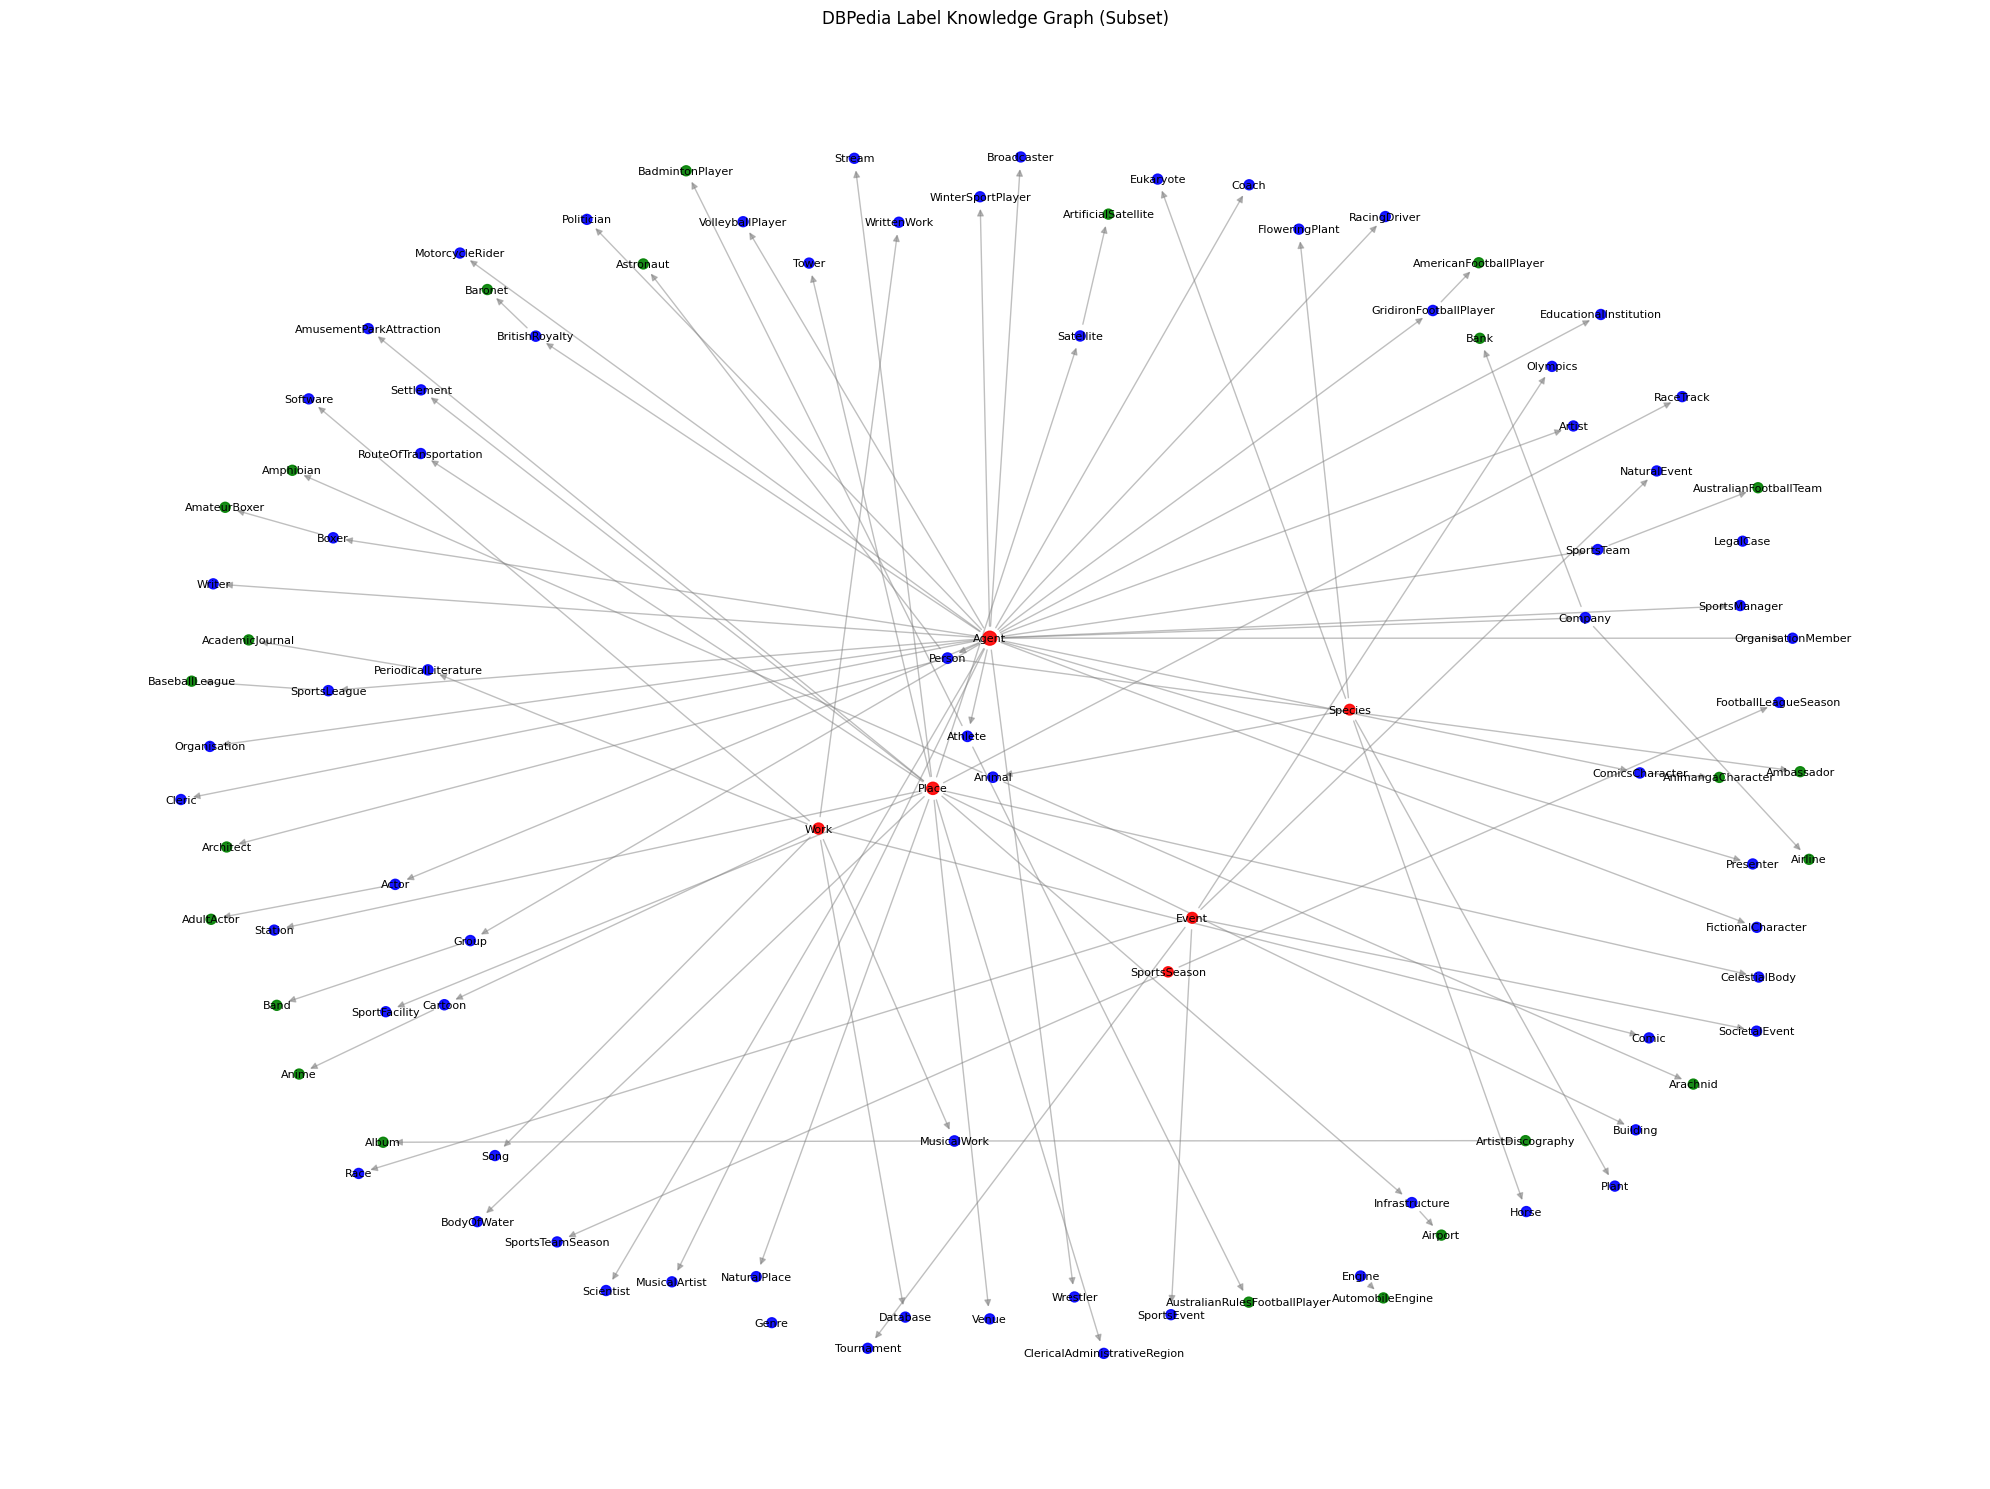

Visualization displayed.


In [36]:
if G is not None:
    # Example 1: Visualize top N nodes (default)
    visualize_knowledge_graph(G)

    # Example 2: Visualize a specific hierarchy (e.g., 'Work') up to depth 2
    # You might need to check the exact name of the root node in your data ('Work', 'Agent', etc.)
    # root_label = 'Work' # Change this to a valid l1 label from your data
    # visualize_knowledge_graph(G, root_node=root_label, depth_limit=2, layout_func=nx.kamada_kawai_layout)

    # Example 3: Attempt to visualize the whole graph (might be slow/messy)
    # visualize_knowledge_graph(G, max_nodes=None, figsize=(30,25))
    pass # Keep examples commented out unless needed

else:
    print("Skipping visualization as graph 'G' is not loaded.")

In [37]:
!pip install torch_geometric


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup
from torch.optim import AdamW # Import AdamW from torch.optim instead
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.utils import from_networkx # To convert NetworkX graph
import networkx as nx
import numpy as np
import pickle
from sklearn.metrics import f1_score, hamming_loss, accuracy_score
from tqdm import tqdm # Use standard tqdm if not in notebook
import random
import warnings
import os
import copy # For saving best model state

warnings.filterwarnings('ignore')

# --- Configuration ---
# Model Hyperparameters
BERT_MODEL_NAME = 'bert-base-uncased'
GRAPH_NODE_EMBED_DIM = 256 # Dimension for initial graph node features (can be BERT hidden size if using BERT features)
GAT_HIDDEN_DIM = 256   # Hidden dimension for GAT layers
GAT_OUTPUT_DIM = 256   # Output dimension after GAT processing
GAT_HEADS = 4          # Number of attention heads in GAT
GAT_DROPOUT = 0.3      # Dropout in GAT layers
CROSS_ATTENTION_HEADS = 4 # Heads for text-graph cross-attention
CROSS_ATTENTION_DROPOUT = 0.2
CLASSIFIER_DROPOUT = 0.3

# Training Hyperparameters
LEARNING_RATE_BERT = 1e-5
LEARNING_RATE_GNN = 1e-4
LEARNING_RATE_OTHER = 1e-4
WEIGHT_DECAY = 0.01
EPOCHS = 5 # Start with fewer epochs, increase as needed
TRAIN_BATCH_SIZE = 128 # Adjust based on GPU memory
VAL_BATCH_SIZE = 128
MAX_LEN = 256 # Max sequence length for BERT tokenizer

# Severity Loss Configuration
SEVERITY_THRESHOLD = 0.5 # Threshold to consider a prediction positive for severity check
# Define weights for severity levels (adjust as needed)
# Higher weight means higher penalty for that severity level
SEVERITY_WEIGHTS = {
    1: 1.5,  # Misclassification within same l2 superclass
    2: 2.5,  # Misclassification within same l1 group, different l2
    3: 4.0   # Misclassification in different l1 group
}
SEVERITY_LOSS_FACTOR = 0.5 # How much the severity penalty contributes to the total loss (0 to 1)

# Paths (ensure these are correct)
SPLIT_DATA_PATH = 'train_val_test_splits.pkl'
GRAPH_PATH = 'dbpedia_label_hierarchy.gpickle'
HIERARCHY_INFO_PATH = 'label_hierarchy_info.pkl'
MODEL_SAVE_PATH = 'severity_aware_classifier_best.pt'

# Device Configuration
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("--- Stage 6: Setup, Imports, and Configuration Complete ---")

Using device: cuda
--- Stage 6: Setup, Imports, and Configuration Complete ---


In [39]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')

# --- Configuration ---
PROCESSED_DATA_LOAD_PATH = 'processed_model_input.pkl' # Load data from Stage 4
SPLIT_DATA_SAVE_PATH = 'train_val_test_splits.pkl' # Save the split data

# Define split ratios
TEST_SIZE = 0.10 # Proportion of data for the test set
VALIDATION_SIZE = 0.10 # Proportion of *original* data for the validation set
# Note: Validation size will be calculated relative to the remaining data after test split

RANDOM_STATE = 42 # For reproducible splits

# --- Load Processed Data ---
print("--- Stage 5: Data Splitting ---")

try:
    print(f"Loading processed data from: {PROCESSED_DATA_LOAD_PATH}")
    with open(PROCESSED_DATA_LOAD_PATH, 'rb') as f:
        data_package = pickle.load(f)
    X = data_package['X']
    y = data_package['y']
    # Keep other items if needed, e.g., for saving with splits
    mlb = data_package['mlb']
    index_to_label = data_package['index_to_label']
    label_to_index = data_package['label_to_index']
    print(f"Loaded {len(X)} samples.")
    if isinstance(X, list) and isinstance(y, np.ndarray):
        print(f"Data types loaded correctly (X: list, y: {type(y)} with shape {y.shape})")
    else:
         print("Warning: Loaded data types might not be as expected.")

except FileNotFoundError:
    print(f"Error: Processed data file not found at {PROCESSED_DATA_LOAD_PATH}. Run Stage 4 first.")
    X, y = None, None # Prevent further execution
except Exception as e:
    print(f"Error loading processed data: {e}")
    X, y = None, None

# --- Perform Splits ---
if X is not None and y is not None:
    print(f"\nSplitting data (Test={TEST_SIZE*100}%, Validation={VALIDATION_SIZE*100}% of original)...")

    # Check if data size is sufficient for splitting
    if len(X) < 3: # Need at least one sample per split typically
        print("Error: Not enough data samples to perform train/validation/test split.")
    else:
        # First split: Separate Test set from the rest
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y,
            test_size=TEST_SIZE,
            random_state=RANDOM_STATE
            # Note: Stratification is complex for multilabel. For large datasets, random split is often okay.
            # For highly imbalanced cases, consider iterative stratification:
            # from skmultilearn.model_selection import iterative_train_test_split
            # X_temp_idx, y_temp, X_test_idx, y_test = iterative_train_test_split(np.arange(len(X))[:,np.newaxis], y, test_size = TEST_SIZE)
            # X_temp = [X[i[0]] for i in X_temp_idx]
            # X_test = [X[i[0]] for i in X_test_idx]
        )

        # Calculate validation size relative to the *remaining* data (X_temp)
        # val_size_adjusted = val_size / (1 - test_size)
        val_size_relative = VALIDATION_SIZE / (1.0 - TEST_SIZE)

        # Second split: Separate Training and Validation sets from X_temp
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp,
            test_size=val_size_relative,
            random_state=RANDOM_STATE # Use same random state for consistency in this step
            # Again, consider iterative stratification if needed for y_temp
        )

        print("\nSplit complete. Data shapes:")
        print(f"  Training:   X_train ({len(X_train)} samples), y_train ({y_train.shape})")
        print(f"  Validation: X_val ({len(X_val)} samples), y_val ({y_val.shape})")
        print(f"  Test:       X_test ({len(X_test)} samples), y_test ({y_test.shape})")

        # --- Save the Splits ---
        print(f"\nAttempting to save data splits to: {SPLIT_DATA_SAVE_PATH}")
        try:
            split_data_package = {
                'X_train': X_train, 'y_train': y_train,
                'X_val': X_val,     'y_val': y_val,
                'X_test': X_test,   'y_test': y_test,
                # Include mappings and MLB object for convenience during training/evaluation
                'mlb': mlb,
                'index_to_label': index_to_label,
                'label_to_index': label_to_index
            }
            with open(SPLIT_DATA_SAVE_PATH, 'wb') as f:
                pickle.dump(split_data_package, f)
            print("Successfully saved data splits.")

        except Exception as e:
            print(f"Error saving data splits: {e}")

else:
    print("\nSkipping data splitting due to previous loading errors.")

print("\nStage 5 completed.")

# --- Ready for Modeling ---
# You can now load 'train_val_test_splits.pkl' in your training script
# to get X_train, y_train, X_val, y_val, etc.

--- Stage 5: Data Splitting ---
Loading processed data from: processed_model_input.pkl
Loaded 240942 samples.
Data types loaded correctly (X: list, y: <class 'numpy.ndarray'> with shape (240942, 298))

Splitting data (Test=10.0%, Validation=10.0% of original)...

Split complete. Data shapes:
  Training:   X_train (192752 samples), y_train ((192752, 298))
  Validation: X_val (24095 samples), y_val ((24095, 298))
  Test:       X_test (24095 samples), y_test ((24095, 298))

Attempting to save data splits to: train_val_test_splits.pkl
Successfully saved data splits.

Stage 5 completed.


In [40]:
print("\n--- Stage 7: Data Loading & Preparation for PyTorch ---")

# --- Load Data Splits ---
try:
    with open(SPLIT_DATA_PATH, 'rb') as f:
        split_data = pickle.load(f)
    X_train, y_train = split_data['X_train'], split_data['y_train']
    X_val, y_val = split_data['X_val'], split_data['y_val']
    X_test, y_test = split_data['X_test'], split_data['y_test']
    mlb = split_data['mlb']
    index_to_label = split_data['index_to_label']
    label_to_index = split_data['label_to_index']
    all_labels_list = mlb.classes_ # Get ordered list from MLB
    NUM_LABELS = len(all_labels_list)
    print(f"Loaded data splits. Training samples: {len(X_train)}, Num Labels: {NUM_LABELS}")
except FileNotFoundError:
    print(f"Error: Split data file not found at {SPLIT_DATA_PATH}. Cannot proceed.")
    exit()
except Exception as e:
    print(f"Error loading split data: {e}")
    exit()

# --- Load Graph ---
try:
    with open(GRAPH_PATH, 'rb') as f:
        G_nx = pickle.load(f)
    print(f"Loaded NetworkX graph with {G_nx.number_of_nodes()} nodes and {G_nx.number_of_edges()} edges.")
    # Ensure nodes in graph match all_labels_list
    graph_nodes = set(G_nx.nodes())
    mapped_labels = set(all_labels_list)
    if graph_nodes != mapped_labels:
        print("Warning: Nodes in NetworkX graph do not exactly match labels from mapping!")
        print(f" Graph nodes missing from mapping: {graph_nodes - mapped_labels}")
        print(f" Mapping labels missing from graph: {mapped_labels - graph_nodes}")
        # Option: Rebuild graph strictly from all_labels_list if necessary, or handle missing nodes later
    # Create mapping from label string to graph node index (0 to NUM_LABELS-1) based on all_labels_list order
    node_string_to_graph_idx = {label: i for i, label in enumerate(all_labels_list)}

except FileNotFoundError:
    print(f"Error: Graph file not found at {GRAPH_PATH}. Cannot use GNN component.")
    G_nx = None
except Exception as e:
    print(f"Error loading graph: {e}")
    G_nx = None

# --- Load Hierarchy Info (Crucial for Severity Loss) ---
try:
    with open(HIERARCHY_INFO_PATH, 'rb') as f:
        # Original hierarchy info is keyed by OLD index. We need it keyed by LABEL STRING for easy lookup.
        _label_hierarchy_info_by_idx = pickle.load(f)
        label_hierarchy_info = {}
        missing_hierarchy_count = 0
        for idx, info in _label_hierarchy_info_by_idx.items():
            label_str = info.get('label')
            if label_str in label_to_index: # Check if label is in our final list
                 label_hierarchy_info[label_str] = info
            else:
                 missing_hierarchy_count += 1
        print(f"Loaded hierarchy info. Found info for {len(label_hierarchy_info)} labels.")
        if missing_hierarchy_count > 0:
            print(f"Warning: {missing_hierarchy_count} labels from hierarchy info file were not in the final label mapping.")
        # Add check to ensure all labels in final mapping have hierarchy info
        for label in all_labels_list:
            if label not in label_hierarchy_info:
                print(f"CRITICAL WARNING: Label '{label}' from final mapping is missing hierarchy info! Severity loss may fail.")
                # Attempt to add default info - NEEDS CAREFUL REVIEW
                label_hierarchy_info[label] = {'label': label, 'l1': label, 'l2': None, 'l3': None, 'level': 1} # Default assumption


except FileNotFoundError:
    print(f"Error: Hierarchy info file not found at {HIERARCHY_INFO_PATH}. Cannot calculate severity loss.")
    label_hierarchy_info = None
    exit()
except Exception as e:
    print(f"Error loading hierarchy info: {e}")
    label_hierarchy_info = None
    exit()

# --- Prepare Graph Data for PyG ---
graph_data = None
if G_nx is not None:
    print("Preparing graph data for PyTorch Geometric...")
    # Initialize node features (Option 1: Random, Option 2: Use BERT)

    # Option 1: Random Initialization
    # node_features = torch.randn((NUM_LABELS, GRAPH_NODE_EMBED_DIM), device=DEVICE)

    # Option 2: BERT embeddings of label names (more informative but slower setup)
    print("Generating initial node features using BERT embeddings of label names...")
    tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)
    bert_model_for_nodes = BertModel.from_pretrained(BERT_MODEL_NAME).to(DEVICE)
    bert_model_for_nodes.eval() # Set to evaluation mode
    node_features_list = []
    with torch.no_grad():
        for i in tqdm(range(NUM_LABELS), desc="Embedding Labels"):
            label_name = all_labels_list[i]
            # Simple preprocessing for label name (e.g., handle CamelCase)
            processed_label_name = ' '.join(re.findall(r'[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)|[0-9]+', label_name))
            inputs = tokenizer(processed_label_name, return_tensors='pt', padding=True, truncation=True, max_length=32) # Short max_len for labels
            inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
            outputs = bert_model_for_nodes(**inputs)
            # Use the [CLS] token embedding
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu()
            node_features_list.append(cls_embedding)
    node_features = torch.stack(node_features_list).to(DEVICE)
    # Set the embedding dim based on BERT's output if needed
    GRAPH_NODE_EMBED_DIM = node_features.shape[1]
    print(f"Node features created with shape: {node_features.shape}")
    # Clean up GPU memory
    del bert_model_for_nodes
    torch.cuda.empty_cache()

    # Convert NetworkX graph to PyG Data object
    # Important: Ensure node order in PyG matches all_labels_list (0 to NUM_LABELS-1)
    # We need to relabel nodes in G_nx to indices 0...N-1 before conversion
    G_relabelled = nx.relabel_nodes(G_nx, node_string_to_graph_idx, copy=True)

    # Add missing nodes if any (should correspond to labels not in graph edges)
    for i in range(NUM_LABELS):
         if i not in G_relabelled:
             G_relabelled.add_node(i) # Add isolated nodes

    # Convert to PyG Data object
    graph_data = from_networkx(G_relabelled)
    graph_data.x = node_features # Assign features
    graph_data = graph_data.to(DEVICE) # Move entire graph data to device
    print("Graph data converted to PyTorch Geometric format and moved to device.")
    print(graph_data)
else:
    print("Skipping PyG graph preparation as NetworkX graph was not loaded.")


# --- Tokenize Text Data ---
print("Initializing BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

print("Tokenizing text data...")
def tokenize_data(texts, max_len):
    return tokenizer(
        texts,
        max_length=max_len,
        padding='max_length', # Pad to max_len
        truncation=True,      # Truncate longer sequences
        return_tensors='pt'   # Return PyTorch tensors
    )

# Takes time, especially for large datasets
X_train_tokens = tokenize_data(X_train, MAX_LEN)
X_val_tokens = tokenize_data(X_val, MAX_LEN)
X_test_tokens = tokenize_data(X_test, MAX_LEN)
print("Tokenization complete.")

# --- Create PyTorch Datasets ---
class TextGraphDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32) # Ensure labels are float tensors

    def __getitem__(self, idx):
        # Extract input_ids, attention_mask, etc. for the given index
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        # Number of samples is the length of the first tensor in encodings (e.g., input_ids)
        return len(self.labels)

train_dataset = TextGraphDataset(X_train_tokens, y_train)
val_dataset = TextGraphDataset(X_val_tokens, y_val)
test_dataset = TextGraphDataset(X_test_tokens, y_test)
print("PyTorch datasets created.")

# --- Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False)
print("PyTorch DataLoaders created.")

print("\n--- Stage 7: Data Loading & Preparation Complete ---")


--- Stage 7: Data Loading & Preparation for PyTorch ---
Loaded data splits. Training samples: 192752, Num Labels: 298
Loaded NetworkX graph with 298 nodes and 289 edges.
Loaded hierarchy info. Found info for 298 labels.
Preparing graph data for PyTorch Geometric...
Generating initial node features using BERT embeddings of label names...


Embedding Labels: 100%|██████████| 298/298 [00:01<00:00, 169.61it/s]


Node features created with shape: torch.Size([298, 768])
Graph data converted to PyTorch Geometric format and moved to device.
Data(edge_index=[2, 289], level=[298], num_nodes=298, x=[298, 768])
Initializing BERT tokenizer...
Tokenizing text data...
Tokenization complete.
PyTorch datasets created.
PyTorch DataLoaders created.

--- Stage 7: Data Loading & Preparation Complete ---


In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel
from torch_geometric.nn import GATConv
import re # Needed for label name processing if using BERT features

print("\n--- Stage 8: Model Definition (Corrected) ---")

class SeverityAwareGraphTextModel(nn.Module):
    def __init__(self, bert_model_name, num_labels, graph_data,
                 gat_hidden_dim, gat_output_dim, gat_heads, gat_dropout, # <--- gat_dropout is here
                 cross_attention_heads, cross_attention_dropout,
                 classifier_dropout, device):
        super().__init__()
        self.num_labels = num_labels
        self.graph_data = graph_data
        self.device = device
        # Store gat_dropout as instance attribute
        self.gat_dropout = gat_dropout # <<< ADD THIS LINE

        # Text Encoder
        print("Initializing BERT model...")
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.bert_hidden_size = self.bert.config.hidden_size

        # Graph Encoder (only if graph_data exists)
        self.gat1 = None
        self.gat2 = None
        self.graph_output_dim = 0
        if self.graph_data is not None:
            print("Initializing GAT layers...")
            graph_input_dim = self.graph_data.x.shape[1]
            self.graph_node_proj = nn.Linear(graph_input_dim, gat_hidden_dim)
            # Pass self.gat_dropout to GATConv init
            self.gat1 = GATConv(gat_hidden_dim, gat_hidden_dim, heads=gat_heads, dropout=self.gat_dropout)
            self.gat2 = GATConv(gat_hidden_dim * gat_heads, gat_output_dim, heads=1, concat=False, dropout=self.gat_dropout)
            self.graph_output_dim = gat_output_dim
            print("GAT layers initialized.")

        # Cross-Attention Module
        print("Initializing Cross-Attention layers...")
        self.use_graph = self.graph_data is not None and self.graph_output_dim > 0
        if self.use_graph:
            self.txt_to_graph_attn = nn.MultiheadAttention(
                embed_dim=self.bert_hidden_size, kdim=self.graph_output_dim,
                vdim=self.graph_output_dim, num_heads=cross_attention_heads,
                dropout=cross_attention_dropout, batch_first=True
            )
            self.graph_to_txt_attn = nn.MultiheadAttention(
                embed_dim=self.graph_output_dim, kdim=self.bert_hidden_size,
                vdim=self.bert_hidden_size, num_heads=cross_attention_heads,
                dropout=cross_attention_dropout, batch_first=True
            )
            self.norm1 = nn.LayerNorm(self.bert_hidden_size)
            self.norm2 = nn.LayerNorm(self.graph_output_dim)
            self.norm3 = nn.LayerNorm(self.graph_output_dim)
            fusion_input_dim = self.bert_hidden_size + self.graph_output_dim + self.graph_output_dim
            self.fusion_layer = nn.Sequential(
                nn.Linear(fusion_input_dim, fusion_input_dim // 2),
                nn.ReLU(),
                nn.Dropout(classifier_dropout) # Use classifier_dropout here
            )
            final_classifier_input_dim = fusion_input_dim // 2
            print("Cross-Attention layers initialized.")
        else:
            print("Graph data not available, skipping GAT and Cross-Attention.")
            # Define norm1 even if graph isn't used, for consistency before classifier
            self.norm1 = nn.LayerNorm(self.bert_hidden_size)
            final_classifier_input_dim = self.bert_hidden_size

        # Classifier Head
        print("Initializing Classifier head...")
        self.classifier = nn.Linear(final_classifier_input_dim, num_labels)
        print("Classifier head initialized.")


    def forward(self, input_ids, attention_mask):
        bert_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_cls_embedding = bert_outputs.last_hidden_state[:, 0, :]
        text_token_embeddings = bert_outputs.last_hidden_state

        if self.use_graph:
            x, edge_index = self.graph_data.x, self.graph_data.edge_index
            x = self.graph_node_proj(x)
            # Use self.gat_dropout here
            x = F.dropout(x, p=self.gat_dropout, training=self.training) # <<< CORRECTED
            x = F.elu(self.gat1(x, edge_index))
            # And here
            x = F.dropout(x, p=self.gat_dropout, training=self.training) # <<< CORRECTED
            graph_node_embeddings = self.gat2(x, edge_index)

            batch_size = input_ids.shape[0]
            graph_nodes_batch = graph_node_embeddings.unsqueeze(0).expand(batch_size, -1, -1)

            attended_graph_info, _ = self.txt_to_graph_attn(
                text_cls_embedding.unsqueeze(1), graph_nodes_batch, graph_nodes_batch
            )
            attended_graph_info = attended_graph_info.squeeze(1)
            attended_graph_info = self.norm2(attended_graph_info)

            attended_text_info_per_node, _ = self.graph_to_txt_attn(
                 graph_nodes_batch, text_token_embeddings, text_token_embeddings,
                 key_padding_mask=(attention_mask == 0)
            )
            attended_text_info_per_node = self.norm3(attended_text_info_per_node)
            global_attended_text_info = attended_text_info_per_node.mean(dim=1)

            fused_representation = torch.cat(
                (self.norm1(text_cls_embedding), attended_graph_info, global_attended_text_info),
                 dim=1
            )
            fused_representation = self.fusion_layer(fused_representation)

        else:
             # Apply LayerNorm before classifier even in text-only mode
             fused_representation = self.norm1(text_cls_embedding)

        logits = self.classifier(fused_representation)

        return logits

print("Model class defined (Corrected).")

# --- Re-instantiate the model with the corrected class definition ---
print("\nRe-instantiating the model...")
# Ensure all necessary config variables are defined before this point
# Load graph_data again IF you generated the pickle file, otherwise keep it None
graph_data = None # Keep None if you are running without the graph file
if os.path.exists(GRAPH_PATH): # Check if graph file exists now
    try:
        print(f"Loading graph file {GRAPH_PATH} for model instantiation...")
        with open(GRAPH_PATH, 'rb') as f:
            G_nx_load = pickle.load(f) # Load with standard pickle
        # Convert to PyG Data here if needed (copy relevant logic from Stage 7)
        # ... (logic to create node_features, relabel G_nx_load, use from_networkx) ...
        # graph_data = converted_pyg_data.to(DEVICE)
        print("Graph loaded successfully (logic to convert to PyG data needed here).")
        # For now, we'll assume graph_data remains None if conversion logic isn't added back
        graph_data = None # Remove this line if you add the conversion logic back

    except Exception as e:
        print(f"Error loading graph file during model re-instantiation: {e}")
        graph_data = None


model = SeverityAwareGraphTextModel(
    bert_model_name=BERT_MODEL_NAME,
    num_labels=NUM_LABELS,
    graph_data=graph_data, # Pass None or the loaded PyG data
    gat_hidden_dim=GAT_HIDDEN_DIM,
    gat_output_dim=GAT_OUTPUT_DIM,
    gat_heads=GAT_HEADS,
    gat_dropout=GAT_DROPOUT, # Pass the config value
    cross_attention_heads=CROSS_ATTENTION_HEADS,
    cross_attention_dropout=CROSS_ATTENTION_DROPOUT,
    classifier_dropout=CLASSIFIER_DROPOUT,
    device=DEVICE
)

model.to(DEVICE)

print("\nModel Re-Instantiated with corrected class and moved to device.")
# Optional: Re-apply freezing if needed
num_trainable_check = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Re-checking trainable parameters: {num_trainable_check:,}")
# Apply freezing if needed (copy freezing logic here if it wasn't permanent)
# ... (freezing logic from previous step) ...


print("\n--- Stage 8 Complete (Corrected) ---")

# --- You should now be able to re-run Stage 9 (Loss Definition) ---
# Although Stage 9 code doesn't change, re-running ensures the 'criterion'
# variable is correctly defined before Stage 10.
# Then, re-run Stage 10 (Training Loop).


--- Stage 8: Model Definition (Corrected) ---
Model class defined (Corrected).

Re-instantiating the model...
Loading graph file dbpedia_label_hierarchy.gpickle for model instantiation...
Graph loaded successfully (logic to convert to PyG data needed here).
Initializing BERT model...
Initializing Cross-Attention layers...
Graph data not available, skipping GAT and Cross-Attention.
Initializing Classifier head...
Classifier head initialized.

Model Re-Instantiated with corrected class and moved to device.
Re-checking trainable parameters: 109,712,938

--- Stage 8 Complete (Corrected) ---


In [42]:
print("\n--- Stage 9: Severity-Aware Loss Function Definition ---")

class SeverityAwareLoss(nn.Module):
    def __init__(self, label_hierarchy_info, index_to_label, severity_weights,
                 severity_threshold=0.5, severity_factor=0.5, reduction='mean'):
        """
        Args:
            label_hierarchy_info (dict): Maps label string to {'l1', 'l2', 'l3', ...}
            index_to_label (dict): Maps model output index to label string.
            severity_weights (dict): Maps severity level (1, 2, 3) to weight multiplier.
            severity_threshold (float): Probability threshold to consider a prediction positive.
            severity_factor (float): Weighting factor for the severity penalty term (0 to 1).
            reduction (str): 'mean' or 'sum' for the final loss.
        """
        super().__init__()
        self.label_hierarchy_info = label_hierarchy_info
        self.index_to_label = index_to_label
        self.num_labels = len(index_to_label)
        self.severity_weights = severity_weights
        self.severity_threshold = severity_threshold
        self.severity_factor = severity_factor
        self.reduction = reduction
        # Use BCEWithLogitsLoss for numerical stability
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none') # Calculate loss per element

    def get_severity(self, predicted_label_str, true_label_strs):
        """Calculates the maximum severity between a predicted label and true labels."""
        if not true_label_strs: # No true labels for this sample? Should not happen in multilabel.
            return 0 # No penalty if no ground truth

        pred_info = self.label_hierarchy_info.get(predicted_label_str)
        if not pred_info:
            # print(f"Warning: Hierarchy info missing for predicted label '{predicted_label_str}'")
            return 0 # Cannot calculate severity without info

        max_severity = 0 # Default to 0 (no error or lowest severity if it's actually a TP)

        for true_label_str in true_label_strs:
            true_info = self.label_hierarchy_info.get(true_label_str)
            if not true_info:
                # print(f"Warning: Hierarchy info missing for true label '{true_label_str}'")
                continue # Skip comparison if true info missing

            # Compare hierarchies
            current_severity = 0
            if pred_info['l1'] != true_info['l1']:
                current_severity = 3 # Different group
            elif pred_info['l2'] != true_info['l2'] and true_info['l2'] is not None and pred_info['l2'] is not None:
                 current_severity = 2 # Same group, different superclass
            elif pred_info['l3'] != true_info['l3'] and true_info['l3'] is not None and pred_info['l3'] is not None:
                 current_severity = 1 # Same superclass, different specific class
            # Consider cases where one path is shorter (e.g., true is l2, pred is l3 in same l2) - severity 1?
            elif pred_info['l2'] == true_info['l2'] and (true_info['l3'] is None or pred_info['l3'] is None):
                 current_severity = 1 # Within the same superclass still

            max_severity = max(max_severity, current_severity)

        return max_severity

    def forward(self, logits, targets):
        """
        Args:
            logits (torch.Tensor): Raw output from the model (batch_size, num_labels).
            targets (torch.Tensor): Ground truth labels (batch_size, num_labels), multi-hot encoded (0.0 or 1.0).
        """
        # 1. Calculate standard BCE loss per element
        standard_loss = self.bce_loss(logits, targets) # (batch_size, num_labels)

        # 2. Calculate severity weights per element
        severity_penalty_weights = torch.ones_like(logits) # Start with weight 1 everywhere

        # Apply sigmoid to get probabilities for thresholding
        probs = torch.sigmoid(logits)

        # Iterate through batch and labels to find misclassifications (focus on False Positives for severity)
        for i in range(logits.shape[0]): # Batch dimension
            true_indices = torch.where(targets[i] == 1)[0]
            true_label_strs = [self.index_to_label[idx.item()] for idx in true_indices]

            for j in range(logits.shape[1]): # Label dimension
                # Check for False Positive: Predicted positive, but target is negative
                if probs[i, j] > self.severity_threshold and targets[i, j] == 0:
                    predicted_label_str = self.index_to_label[j]
                    severity_level = self.get_severity(predicted_label_str, true_label_strs)

                    if severity_level > 0:
                         # Get the corresponding weight multiplier
                         severity_weight = self.severity_weights.get(severity_level, 1.0) # Default to 1 if level invalid
                         severity_penalty_weights[i, j] = severity_weight

        # 3. Apply severity weights to the standard loss
        weighted_loss = standard_loss * severity_penalty_weights

        # 4. Combine standard loss and weighted loss (optional weighting factor)
        # Option A: Only use weighted loss
        # final_loss_per_element = weighted_loss
        # Option B: Interpolate between standard and weighted using severity_factor
        final_loss_per_element = (1 - self.severity_factor) * standard_loss + self.severity_factor * weighted_loss

        # 5. Reduce the loss
        if self.reduction == 'mean':
            return final_loss_per_element.mean()
        elif self.reduction == 'sum':
            return final_loss_per_element.sum()
        else:
            return final_loss_per_element # No reduction

# Instantiate the loss function
criterion = SeverityAwareLoss(
    label_hierarchy_info=label_hierarchy_info,
    index_to_label=index_to_label,
    severity_weights=SEVERITY_WEIGHTS,
    severity_threshold=SEVERITY_THRESHOLD,
    severity_factor=SEVERITY_LOSS_FACTOR,
    reduction='mean'
)
print("Severity-aware loss function instantiated.")

print("\n--- Stage 9: Severity-Aware Loss Function Definition Complete ---")


--- Stage 9: Severity-Aware Loss Function Definition ---
Severity-aware loss function instantiated.

--- Stage 9: Severity-Aware Loss Function Definition Complete ---


In [43]:
# Example (add after model instantiation in Stage 8 or before optimizer in Stage 10)
print("Freezing BERT layers except the top one...")
for name, param in model.bert.named_parameters():
    # Freeze all layers except the pooler and the last encoder layer
    if not name.startswith('pooler.') and 'encoder.layer.11.' not in name:
         param.requires_grad = False
num_frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
num_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Froze {num_frozen:,} parameters. Trainable: {num_trainable:,}")

Freezing BERT layers except the top one...
Froze 101,803,776 parameters. Trainable: 7,909,162


In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# Corrected imports:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW # Import AdamW from torch.optim instead
# --- rest of the necessary imports ----
import numpy as np
import pickle
from sklearn.metrics import f1_score, hamming_loss, accuracy_score, classification_report
from tqdm import tqdm # Or standard tqdm
import time
import os
import copy # For saving best model state
import warnings

warnings.filterwarnings('ignore')

print("\n--- Stage 10: Optimizer, Scheduler, Training & Evaluation Loops ---")

# --- Configuration (Load necessary variables or redefine) ---
# Load relevant configs from Stage 6 if needed
# BERT_MODEL_NAME, LEARNING_RATE_BERT, LEARNING_RATE_GNN, LEARNING_RATE_OTHER,
# WEIGHT_DECAY, EPOCHS, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, MAX_LEN,
# SEVERITY_THRESHOLD, MODEL_SAVE_PATH, DEVICE, SEED

# --- Load Data Splits (Need loaders) ---
SPLIT_DATA_PATH = 'train_val_test_splits.pkl'
try:
    with open(SPLIT_DATA_PATH, 'rb') as f:
        split_data = pickle.load(f)
    # We mainly need the DataLoaders now, assuming they were created in Stage 7
    # If not, recreate them here using split_data['X_train'], etc. and the Dataset class
    # For simplicity, assuming train_loader, val_loader, test_loader exist from Stage 7 run
    print("Assuming train_loader, val_loader, test_loader exist from Stage 7.")
    # Load mappings if needed for evaluation report
    index_to_label = split_data['index_to_label']
    all_labels_list = split_data['mlb'].classes_ # Get target names
except FileNotFoundError:
    print(f"Error: Split data file not found at {SPLIT_DATA_PATH}. Cannot proceed.")
    exit()
except NameError:
    print("Error: DataLoaders (train_loader, val_loader) not found. Ensure Stage 7 ran successfully.")
    exit()
except Exception as e:
    print(f"Error loading/accessing split data or loaders: {e}")
    exit()

# --- Load Model (Assuming 'model' exists from Stage 8) ---
if 'model' not in locals() or model is None:
    print("Error: Model object not found. Ensure Stage 8 ran successfully.")
    exit()
else:
    print("Using model instance created in Stage 8.")
    # --- Optional: Apply Freezing Here if not done in Stage 8 ---
    # Check if freezing was already applied by counting parameters
    num_trainable_check = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Checking trainable parameters before optimizer setup: {num_trainable_check:,}")
    # if num_trainable_check > 50_000_000: # Heuristic: if >50M, BERT probably not frozen yet
    #      print("Applying BERT freezing...")
    #      for name, param in model.bert.named_parameters():
    #          # Example: Freeze all except pooler and last layer
    #          if not name.startswith('pooler.') and 'encoder.layer.11.' not in name:
    #               param.requires_grad = False
    #      num_frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    #      num_trainable_check = sum(p.numel() for p in model.parameters() if p.requires_grad)
    #      print(f"Froze {num_frozen:,} parameters. Trainable now: {num_trainable_check:,}")


# --- Load Loss Function (Assuming 'criterion' exists from Stage 9) ---
if 'criterion' not in locals() or criterion is None:
    print("Error: Loss function ('criterion') not found. Ensure Stage 9 ran successfully.")
    exit()
else:
    print(f"Using loss function: {type(criterion).__name__}")

# --- Optimizer Setup ---
print("Setting up optimizer with parameter groups...")
# Separate parameters for potentially different learning rates
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']

# Define parameter groups
optimizer_grouped_parameters = [
    # Group 1: BERT parameters (if any are trainable) with weight decay
    {'params': [p for n, p in param_optimizer if 'bert' in n and not any(nd in n for nd in no_decay) and p.requires_grad],
     'weight_decay': WEIGHT_DECAY, 'lr': LEARNING_RATE_BERT},
    # Group 2: BERT parameters without weight decay
    {'params': [p for n, p in param_optimizer if 'bert' in n and any(nd in n for nd in no_decay) and p.requires_grad],
     'weight_decay': 0.0, 'lr': LEARNING_RATE_BERT},

    # Group 3: GAT/Attention parameters (if they exist and are trainable) with weight decay
    {'params': [p for n, p in param_optimizer if ('gat' in n or 'attn' in n or 'graph_node_proj' in n or 'fusion' in n) and not any(nd in n for nd in no_decay) and p.requires_grad],
     'weight_decay': WEIGHT_DECAY, 'lr': LEARNING_RATE_GNN}, # Use GNN rate or OTHER rate
    # Group 4: GAT/Attention parameters without weight decay
    {'params': [p for n, p in param_optimizer if ('gat' in n or 'attn' in n or 'graph_node_proj' in n or 'fusion' in n) and any(nd in n for nd in no_decay) and p.requires_grad],
     'weight_decay': 0.0, 'lr': LEARNING_RATE_GNN},

    # Group 5: Classifier and other parameters with weight decay
    {'params': [p for n, p in param_optimizer if 'bert' not in n and ('gat' not in n and 'attn' not in n and 'graph_node_proj' not in n and 'fusion' not in n) and not any(nd in n for nd in no_decay) and p.requires_grad],
     'weight_decay': WEIGHT_DECAY, 'lr': LEARNING_RATE_OTHER},
    # Group 6: Classifier and other parameters without weight decay
    {'params': [p for n, p in param_optimizer if 'bert' not in n and ('gat' not in n and 'attn' not in n and 'graph_node_proj' not in n and 'fusion' not in n) and any(nd in n for nd in no_decay) and p.requires_grad],
     'weight_decay': 0.0, 'lr': LEARNING_RATE_OTHER},
]

# Filter out empty groups
optimizer_grouped_parameters = [group for group in optimizer_grouped_parameters if group['params']]

if not optimizer_grouped_parameters:
     print("Error: No trainable parameters found for the optimizer!")
     exit()

optimizer = AdamW(optimizer_grouped_parameters)
print(f"Optimizer AdamW initialized with {len(optimizer_grouped_parameters)} parameter groups.")

# --- Scheduler Setup ---
num_training_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(num_training_steps * 0.1) # 10% warmup is common
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)
print(f"Linear scheduler with warmup initialized ({num_warmup_steps} warmup steps, {num_training_steps} total steps).")


# --- Training & Evaluation Functions ---

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    # Use tqdm for progress bar
    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Optional gradient clipping
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()}) # Show current batch loss

    return total_loss / len(data_loader)


def eval_epoch(model, data_loader, loss_fn, device, threshold=0.5):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    # Use tqdm for progress bar
    progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)

    with torch.no_grad(): # Disable gradient calculations
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            # Get predictions
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).cpu().numpy().astype(int) # Apply threshold and convert to numpy int
            labels_np = labels.cpu().numpy().astype(int)

            all_preds.append(preds)
            all_labels.append(labels_np)
            progress_bar.set_postfix({'loss': loss.item()}) # Show current batch loss


    avg_loss = total_loss / len(data_loader)
    # Concatenate predictions and labels from all batches
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Calculate metrics
    metrics = {}
    metrics['loss'] = avg_loss
    metrics['f1_micro'] = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    metrics['f1_macro'] = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    metrics['f1_samples'] = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    metrics['hamming_loss'] = hamming_loss(all_labels, all_preds)
    metrics['accuracy_subset'] = accuracy_score(all_labels, all_preds) # Exact match ratio

    return metrics


# --- Main Training Loop ---
print("\nStarting training...")
best_val_f1_macro = -1.0 # Initialize best score tracking
best_model_state = None
history = {'train_loss': [], 'val_loss': [], 'val_f1_micro': [], 'val_f1_macro': [], 'val_f1_samples': []}
patience = 3 # Number of epochs to wait for improvement before stopping
patience_counter = 0

start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    print(f"\n--- Epoch {epoch + 1}/{EPOCHS} ---")

    # Training
    avg_train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE, scheduler)
    history['train_loss'].append(avg_train_loss)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # Validation
    val_metrics = eval_epoch(model, val_loader, criterion, DEVICE, threshold=SEVERITY_THRESHOLD)
    history['val_loss'].append(val_metrics['loss'])
    history['val_f1_micro'].append(val_metrics['f1_micro'])
    history['val_f1_macro'].append(val_metrics['f1_macro'])
    history['val_f1_samples'].append(val_metrics['f1_samples'])

    print(f"Validation Loss: {val_metrics['loss']:.4f}")
    print(f"Validation F1 Micro: {val_metrics['f1_micro']:.4f}")
    print(f"Validation F1 Macro: {val_metrics['f1_macro']:.4f}")
    print(f"Validation F1 Samples: {val_metrics['f1_samples']:.4f}")
    print(f"Validation Hamming Loss: {val_metrics['hamming_loss']:.4f}")
    print(f"Validation Subset Accuracy: {val_metrics['accuracy_subset']:.4f}")

    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch Duration: {epoch_duration:.2f} seconds")

    # Check for improvement and save best model (using F1 Macro as criterion)
    current_val_f1_macro = val_metrics['f1_macro']
    if current_val_f1_macro > best_val_f1_macro:
        print(f"Validation F1 Macro improved ({best_val_f1_macro:.4f} --> {current_val_f1_macro:.4f}). Saving model...")
        best_val_f1_macro = current_val_f1_macro
        # Use deepcopy to avoid saving reference to model changing during training
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(best_model_state, MODEL_SAVE_PATH)
        patience_counter = 0 # Reset patience counter
    else:
        patience_counter += 1
        print(f"Validation F1 Macro did not improve ({best_val_f1_macro:.4f}). Patience: {patience_counter}/{patience}")

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break

total_training_time = time.time() - start_time
print(f"\n--- Training Finished ---")
print(f"Total Training Time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")
print(f"Best Validation F1 Macro achieved: {best_val_f1_macro:.4f}")


# --- Load Best Model for Final Evaluation ---
if best_model_state is not None:
    print("\nLoading best model state for final evaluation...")
    model.load_state_dict(best_model_state)
else:
     print("\nWarning: No best model state saved (perhaps training stopped early or didn't improve). Evaluating last model state.")



--- Stage 10: Optimizer, Scheduler, Training & Evaluation Loops ---
Assuming train_loader, val_loader, test_loader exist from Stage 7.
Using model instance created in Stage 8.
Checking trainable parameters before optimizer setup: 7,909,162
Using loss function: SeverityAwareLoss
Setting up optimizer with parameter groups...
Optimizer AdamW initialized with 4 parameter groups.
Linear scheduler with warmup initialized (753 warmup steps, 7530 total steps).

Starting training...

--- Epoch 1/5 ---


Average Training Loss: 0.1749


Validation Loss: 0.0262
Validation F1 Micro: 0.5132
Validation F1 Macro: 0.0379
Validation F1 Samples: 0.4826
Validation Hamming Loss: 0.0068
Validation Subset Accuracy: 0.0000
Epoch Duration: 2372.97 seconds
Validation F1 Macro improved (-1.0000 --> 0.0379). Saving model...

--- Epoch 2/5 ---


Average Training Loss: 0.0177


Validation Loss: 0.0097
Validation F1 Micro: 0.8531
Validation F1 Macro: 0.4483
Validation F1 Samples: 0.8245
Validation Hamming Loss: 0.0027
Validation Subset Accuracy: 0.4951
Epoch Duration: 2259.07 seconds
Validation F1 Macro improved (0.0379 --> 0.4483). Saving model...

--- Epoch 3/5 ---


Average Training Loss: 0.0090


Validation Loss: 0.0059
Validation F1 Micro: 0.9161
Validation F1 Macro: 0.6398
Validation F1 Samples: 0.8993
Validation Hamming Loss: 0.0016
Validation Subset Accuracy: 0.7139
Epoch Duration: 2228.83 seconds
Validation F1 Macro improved (0.4483 --> 0.6398). Saving model...

--- Epoch 4/5 ---


Average Training Loss: 0.0064


Validation Loss: 0.0047
Validation F1 Micro: 0.9341
Validation F1 Macro: 0.7287
Validation F1 Samples: 0.9224
Validation Hamming Loss: 0.0013
Validation Subset Accuracy: 0.7842
Epoch Duration: 2212.61 seconds
Validation F1 Macro improved (0.6398 --> 0.7287). Saving model...

--- Epoch 5/5 ---


Average Training Loss: 0.0055


Validation Loss: 0.0044
Validation F1 Micro: 0.9389
Validation F1 Macro: 0.7601
Validation F1 Samples: 0.9285
Validation Hamming Loss: 0.0012
Validation Subset Accuracy: 0.8032
Epoch Duration: 2184.94 seconds
Validation F1 Macro improved (0.7287 --> 0.7601). Saving model...

--- Training Finished ---
Total Training Time: 11271.60 seconds (187.86 minutes)
Best Validation F1 Macro achieved: 0.7601

Loading best model state for final evaluation...


In [46]:
# --- Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set ---")
test_metrics = eval_epoch(model, test_loader, criterion, DEVICE, threshold=SEVERITY_THRESHOLD)

print("\nTest Set Performance:")
print(f"  Test Loss: {test_metrics['loss']:.4f}")
print(f"  Test F1 Micro: {test_metrics['f1_micro']:.4f}")
print(f"  Test F1 Macro: {test_metrics['f1_macro']:.4f}")
print(f"  Test F1 Samples: {test_metrics['f1_samples']:.4f}")
print(f"  Test Hamming Loss: {test_metrics['hamming_loss']:.4f}")
print(f"  Test Subset Accuracy: {test_metrics['accuracy_subset']:.4f}")

# --- Optional: Detailed Classification Report ---
print("\nGenerating detailed classification report on test set...")
# Get final predictions on the test set
all_preds_test = []
all_labels_test = []
model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Getting Test Preds"):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'] # Keep on CPU for report
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.sigmoid(outputs)
        preds = (probs > SEVERITY_THRESHOLD).cpu().numpy().astype(int)
        all_preds_test.append(preds)
        all_labels_test.append(labels.numpy().astype(int))

all_preds_test = np.concatenate(all_preds_test, axis=0)
all_labels_test = np.concatenate(all_labels_test, axis=0)

try:
    report = classification_report(
        all_labels_test,
        all_preds_test,
        target_names=all_labels_list, # Use label names from mapping
        zero_division=0,
        digits=3
    )
    print("\nClassification Report (Test Set):\n")
    print(report)
    # Save report to file
    with open("classification_report_test.txt", "w") as f:
         f.write(report)
    print("Classification report saved to classification_report_test.txt")

except ValueError as e:
    print(f"\nCould not generate detailed classification report: {e}")
    print("This might happen if some labels have no predicted or true samples in the test set.")


print("\n--- Stage 10 Complete ---")


--- Evaluating on Test Set ---



Test Set Performance:
  Test Loss: 0.0044
  Test F1 Micro: 0.9379
  Test F1 Macro: 0.7564
  Test F1 Samples: 0.9277
  Test Hamming Loss: 0.0012
  Test Subset Accuracy: 0.8015

Generating detailed classification report on test set...


Getting Test Preds: 100%|██████████| 189/189 [01:22<00:00,  2.30it/s]



Classification Report (Test Set):

                                   precision    recall  f1-score   support

                  AcademicJournal      0.940     0.926     0.933       203
                            Actor      0.944     0.730     0.824       115
                       AdultActor      0.967     0.674     0.795        86
                            Agent      0.991     0.983     0.987     12413
                          Airline      0.985     1.000     0.993       200
                          Airport      1.000     0.982     0.991       168
                            Album      0.900     0.835     0.866       194
                     AmateurBoxer      1.000     0.071     0.133        28
                       Ambassador      1.000     0.050     0.095        40
           AmericanFootballPlayer      0.973     0.922     0.947       193
                        Amphibian      0.980     0.862     0.917       174
          AmusementParkAttraction      1.000     0.984     0.99